In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.makedirs('/content/drive/MyDrive/geo/',exist_ok=True)

import os
os.makedirs('/content/drive/MyDrive/geo/predictions_rcnn/',exist_ok=True)

# Import
!pip install rasterio
from sklearn.metrics import precision_recall_curve, auc

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/geo

/content/drive/MyDrive/geo


In [ ]:
import os
import torch
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.optim as optim
import torch.nn as nn
import pandas as pd

# Custom Dataset Class for 8-Channel Segmentation
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transform=None, is_test=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths if not is_test else None
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if not is_test:
            for img_path, mask_path in zip(image_paths, mask_paths):
                if os.path.exists(img_path) and os.path.exists(mask_path):
                    self.samples.append((img_path, mask_path))
        else:
            for img_path in image_paths:
                if os.path.exists(img_path):
                    self.samples.append((img_path, None))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, mask_path = self.samples[idx]
        preprocessing = Preprocessing(image_path)
        image = preprocessing.preprocess_image()
        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)  # (C, H, W)

        if self.is_test:
            return image, {"image_id": torch.tensor([idx])}
        else:
            mask = plt.imread(mask_path)

            # Convert mask to grayscale (if it has extra channels)
            if mask.ndim == 3:
                mask = mask[..., 0]  # Take only the first channel

            # Create a writable copy of the mask
            mask = mask.copy()  # Make the mask writable

            # Convert mask values to integers (0 for background, 1 for class)
            mask[mask == -9999] = 0  # Set -9999 as background
            mask[mask == 1] = 1       # Set 1 as the foreground class

            # Ensure it's a 2D tensor (H, W) and correct dtype
            mask = torch.tensor(mask, dtype=torch.long).squeeze(0)

            if self.transform:
                image = self.transform(image)

            print(mask.shape)  # Check the shape of the mask

            return image, mask  # Image (C, H, W), Mask (H, W)

# Preprocessing Class for 8 Channels
class Preprocessing:
    def __init__(self, image_path):
        self.image_path = image_path

    def load_bands(self):
        with rasterio.open(self.image_path) as src:
            blue = src.read(1)
            green = src.read(2)
            red = src.read(3)
            nir = src.read(4)
            swir1 = src.read(5)
            swir2 = src.read(6)
        return blue, green, red, nir, swir1, swir2

    def preprocess_image(self):
        blue, green, red, nir, swir1, swir2 = self.load_bands()
        ndvi = self.compute_ndvi(red, nir)
        evi = self.compute_evi(nir, red, blue)
        normalized_bands = [self.normalize_band(band) for band in [blue, green, red, nir, swir1, swir2]]
        image = np.stack(normalized_bands + [ndvi, evi], axis=-1)  # Stack 8 channels
        return image

    def normalize_band(self, band):
        return (band - np.min(band)) / (np.max(band) - np.min(band))

    def compute_ndvi(self, red, nir):
        return (nir - red) / (nir + red + 1e-6)

    def compute_evi(self, nir, red, blue, g=2.5, c1=6, c2=7.5, l=1):
        return np.clip(g * (nir - red) / (nir + c1 * red - c2 * blue + l), 0, 1)

# Training and Model Setup
class DeepLabV3Model:
    def __init__(self, num_classes=2, device='cuda'):
        self.device = device
        self.model = deeplabv3_resnet50(pretrained=True)

        # Modify input layer to accept 8 channels
        in_features = self.model.backbone.conv1.in_channels
        self.model.backbone.conv1 = nn.Conv2d(8, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify output layer for segmentation classes
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def train(self, dataloader, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, masks in dataloader:
                images, masks = images.to(self.device), masks.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)['out']
                loss = self.criterion(outputs, masks)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader):.4f}")

    def evaluate(self, dataloader):
        self.model.eval()
        iou_scores = []
        with torch.no_grad():
            for images, masks in dataloader:
                images, masks = images.to(self.device), masks.to(self.device)
                outputs = self.model(images)['out']
                preds = torch.argmax(outputs, dim=1)
                intersection = (preds & masks).float().sum()
                union = (preds | masks).float().sum()
                iou_scores.append(intersection / union)
        mean_iou = sum(iou_scores) / len(iou_scores)
        print(f"Mean IoU: {mean_iou:.4f}")

# Load dataset
train_csv = pd.read_csv("train_ds.csv")
test_csv = pd.read_csv("test_ds.csv")

train_image_paths = train_csv["Input"].tolist()
train_mask_paths = train_csv["Label"].tolist()
test_image_paths = test_csv["Input"].tolist()

# Data Transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create Datasets and Dataloaders
train_dataset = CustomSegmentationDataset(image_paths=train_image_paths, mask_paths=train_mask_paths, transform=transform)
test_dataset = CustomSegmentationDataset(image_paths=test_image_paths, is_test=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabV3Model(device=device)
model.train(train_dataloader, num_epochs=10)

# Evaluate the model
model.evaluate(test_dataloader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([256, 256])


<ipython-input-7-9ddcef535a7b>:96: RuntimeWarning: divide by zero encountered in divide
  return np.clip(g * (nir - red) / (nir + c1 * red - c2 * blue + l), 0, 1)


torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


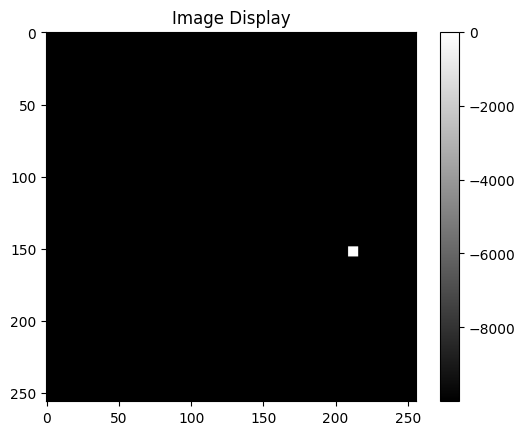

Unique pixel values: [-9999     1]


In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Function to load image and display unique pixel values
def load_and_display_unique_values(image_path):
    with rasterio.open(image_path) as src:
        # Read the image data
        image_data = src.read(1)  # Read the first band (if multi-band, modify as needed)

    # Get unique pixel values in the image
    unique_values = np.unique(image_data)

    # Display the image
    plt.imshow(image_data, cmap='gray')
    plt.colorbar()
    plt.title("Image Display")
    plt.show()

    # Display unique pixel values
    print("Unique pixel values:", unique_values)

# Replace with your image path
image_path = '/content/drive/MyDrive/geo/hls_train/hls_train/seg_maps/seg_map_20160101_L30_T29RKH_2015337T111814_2_5.tif'
load_and_display_unique_values(image_path)
